Chessboard Convolutional Neural Network classifier

In [1]:
import tensorflow as tf
import numpy as np
import PIL
import urllib, cStringIO
import glob
from IPython.core.display import Markdown
from IPython.display import Image, display

import helper_functions as hf
import tensorflow_chessbot

np.set_printoptions(precision=2, suppress=True)

Let's load the tiles in for the training and test dataset, and then split them in a 90/10 ratio

In [2]:
# All tiles with pieces in random organizations
all_paths = np.array(glob.glob("tiles/train_tiles_C/*/*.png")) # TODO : (set labels correctly)

# Shuffle order of paths so when we split the train/test sets the order of files doesn't affect it
np.random.shuffle(all_paths)

ratio = 0.9 # training / testing ratio
divider = int(len(all_paths) * ratio)
train_paths = all_paths[:divider]
test_paths = all_paths[divider:]

# Training dataset
print "Loading %d Training tiles" % train_paths.size
train_images, train_labels = hf.loadFENtiles(train_paths) # Load from generated set

# Test dataset, taken from screenshots of the starting position
print "Loading %d Training tiles" % test_paths.size
test_images, test_labels = hf.loadFENtiles(test_paths) # Load from generated set

train_dataset = hf.DataSet(train_images, train_labels, dtype=tf.float32)
test_dataset = hf.DataSet(test_images, test_labels, dtype=tf.float32)

Loading 8294 Training tiles
. . . . . . . . . Done
Loading 922 Training tiles
. Done


In [3]:
print "Setting up CNN..."
def weight_variable(shape, name=""):
    initial = tf.truncated_normal(shape, stddev=0.1)
    return tf.Variable(initial, name)

def bias_variable(shape, name=""):
    initial = tf.constant(0.1, shape=shape)
    return tf.Variable(initial, name)

def conv2d(x, W):
    return tf.nn.conv2d(x, W, strides=[1, 1, 1, 1], padding='SAME')

def max_pool_2x2(x, name=""):
    return tf.nn.max_pool(x, ksize=[1, 2, 2, 1],
                        strides=[1, 2, 2, 1], padding='SAME', name=name)

x = tf.placeholder(tf.float32, [None, 32*32])

# First layer : 32 features
W_conv1 = weight_variable([5, 5, 1, 32], name='W1')
b_conv1 = bias_variable([32], name='B1')

x_image = tf.reshape(x, [-1,32,32,1])

h_conv1 = tf.nn.relu(conv2d(x_image, W_conv1) + b_conv1, name='Conv1')
h_pool1 = max_pool_2x2(h_conv1, name='Pool1')

# Second convolutional layer : 64 features
W_conv2 = weight_variable([5, 5, 32, 64], name='W2')
b_conv2 = bias_variable([64], name='B2')

h_conv2 = tf.nn.relu(conv2d(h_pool1, W_conv2) + b_conv2, name='Conv2')
h_pool2 = max_pool_2x2(h_conv2, name='Pool2')

# Densely connected layer : 1024 neurons, image size now 8x8
W_fc1 = weight_variable([8 * 8 * 64, 1024], name='W3')
b_fc1 = bias_variable([1024], name='B3')

h_pool2_flat = tf.reshape(h_pool2, [-1, 8*8*64], name='Pool3')
h_fc1 = tf.nn.relu(tf.matmul(h_pool2_flat, W_fc1) + b_fc1, 'MatMult3')

# Dropout
keep_prob = tf.placeholder("float", name='KeepProb')
h_fc1_drop = tf.nn.dropout(h_fc1, keep_prob, name='Drop4')

# Readout layer : softmax, 13 features
W_fc2 = weight_variable([1024, 13], name='W5')
b_fc2 = bias_variable([13], name='B5')

y_conv = tf.nn.softmax(tf.matmul(h_fc1_drop, W_fc2) + b_fc2, name='Ypredict')

# # Old single layer regression classifier
# W = tf.Variable(tf.zeros([32*32, 13]))
# b = tf.Variable(tf.zeros([13]))
# y = tf.nn.softmax(tf.matmul(x, W) + b)

# Ground truth labels if exist 
y_ = tf.placeholder(tf.float32, [None, 13], name='Ytruth')

cross_entropy = -tf.reduce_sum(y_*tf.log(y_conv), name='CrossEntropy')

# train_step = tf.train.GradientDescentOptimizer(0.001).minimize(cross_entropy)
train_step = tf.train.AdamOptimizer(1e-4).minimize(cross_entropy)

correct_prediction = tf.equal(tf.argmax(y_conv,1), tf.argmax(y_,1), name='CorrectPrediction')
accuracy = tf.reduce_mean(tf.cast(correct_prediction, "float"), name='Accuracy')

# Add ops to save and restore all the variables.
saver = tf.train.Saver()

# Start Interactive session for rest of notebook (else we'd want to close session)
sess = tf.InteractiveSession()

# Training vs loading existing model
do_training = False

# Number of steps
N = 10000

if do_training:
    #Initialize session
    sess.run(tf.initialize_all_variables())
    
    # Training
    print "Training for %d steps..." % N
    for i in range(N):
        # Get next batch for training
        batch_xs, batch_ys = train_dataset.next_batch(100)

        # Print out progress to screen
        if ((i+1) % 100) == 0:
            train_accuracy = accuracy.eval(feed_dict={
                x:batch_xs, y_: batch_ys, keep_prob: 1.0})
            print "\n\t%d/%d, training accuracy %g" % (i+1, N, train_accuracy),
        elif ((i+1) % 10) == 0:
            print '.',

        # Train model with batch
        sess.run(train_step, feed_dict={x: batch_xs, y_: batch_ys, keep_prob: 0.5})

    print "Finished training."

    # Save model checkpoint
    save_path = saver.save(sess, "saved_models/model_%d.ckpt" % N)
    print "Model saved in file: ", save_path

else:
    # Restore model from checkpoint
    model_name = "saved_models/model_%d.ckpt" % N
    print "Loading model '%s'" % model_name
    saver.restore(sess, model_name)
    print "Model restored."
    
# Testing
print "Accuracy: %g\n" % accuracy.eval(feed_dict={x: test_dataset.images,
                                                  y_: test_dataset.labels,
                                                  keep_prob: 1.0})


Setting up CNN...
Training for 10000 steps...
. . . . . . . . . 
	100/10000, training accuracy 0.97 . . . . . . . . . 
	200/10000, training accuracy 0.98 . . . . . . . . . 
	300/10000, training accuracy 0.99 . . . . . . . . . 
	400/10000, training accuracy 0.97 . . . . . . . . . 
	500/10000, training accuracy 1 . . . . . . . . . 
	600/10000, training accuracy 0.98 . . . . . . . . . 
	700/10000, training accuracy 0.99 . . . . . . . . . 
	800/10000, training accuracy 1 . . . . . . . . . 
	900/10000, training accuracy 0.99 . . . . . . . . . 
	1000/10000, training accuracy 0.99 . . . . . . . . . 
	1100/10000, training accuracy 1 . . . . . . . . . 
	1200/10000, training accuracy 0.99 . . . . . . . . . 
	1300/10000, training accuracy 1 . . . . . . . . . 
	1400/10000, training accuracy 1 . . . . . . . . . 
	1500/10000, training accuracy 1 . . . . . . . . . 
	1600/10000, training accuracy 1 . . . . . . . . . 
	1700/10000, training accuracy 1 . . . . . . . . . 
	1800/10000, training accuracy 1 

Let's have a look at the failure cases to get a sense of any mistakes

In [4]:
mistakes = tf.where(~correct_prediction)
mistake_indices = sess.run(mistakes, feed_dict={x: test_dataset.images,
                                                y_: test_dataset.labels,
                                               keep_prob: 1.0}).flatten()

guess_prob, guessed = sess.run([y_conv, tf.argmax(y_conv,1)], feed_dict={x: test_dataset.images, keep_prob: 1.0})


if mistake_indices.size > 0:
    print "%d mistakes:" % mistake_indices.size
    for idx in np.random.choice(mistake_indices, 5, replace=False):
        a,b = test_dataset.labels[idx], guessed[idx]
        print "---"
        print "\t#%d | Actual: '%s', Guessed: '%s'" % (idx, hf.label2Name(a),hf.labelIndex2Name(b))
        print "Actual:",a
        print " Guess:",guess_prob[idx,:]
        hf.display_array(np.reshape(test_dataset.images[idx,:],[32,32]))
else:
    print "%d mistakes" % mistake_indices.size

0 mistakes


It looks like it's been learning that pieces have black borders, and since this pieceSet didn't, and it was a small part of the training set, it just fails and thinks we're looking at blank squares, *more training data!* 
From the label probabilities, it did a reasonable job of thinking the pieces were white, and their second best guesses tended to be close to the right answer, the blank spaces just won out.

Also, lets look at several random selections, including successes.

#619 | Actual: ' ', Guessed: ' '


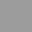

#526 | Actual: 'b', Guessed: 'b'


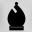

#133 | Actual: 'P', Guessed: 'P'


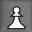

#165 | Actual: 'N', Guessed: 'N'


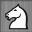

#712 | Actual: 'R', Guessed: 'R'


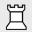

In [5]:
for idx in np.random.choice(test_dataset.num_examples,5,replace=False):
    a,b = test_dataset.labels[idx], guessed[idx]
    print "#%d | Actual: '%s', Guessed: '%s'" % (idx, hf.label2Name(a),hf.labelIndex2Name(b))
    hf.display_array(np.reshape(test_dataset.images[idx,:],[32,32]))

# Predict from image url

Let's wrap up predictions into a single function call from a URL, and test it on a few reddit posts.

In [28]:
def getPrediction(img):
    """Run trained neural network on tiles generated from image"""
    
    # Convert to grayscale numpy array
    img_arr = np.asarray(img.convert("L"), dtype=np.float32)
    
    # Use computer vision to get the tiles
    tiles = tensorflow_chessbot.getTiles(img_arr)
    if tiles is None or len(tiles) == 0:
        print "Couldn't parse chessboard"
        return None, 0.0
    
    # Reshape into Nx1024 rows of input data, format used by neural network
    validation_set = np.swapaxes(np.reshape(tiles, [32*32, 64]),0,1)

    # Run neural network on data
    guess_prob, guessed = sess.run([y_conv, tf.argmax(y_conv,1)], feed_dict={x: validation_set, keep_prob: 1.0})
    
    # Prediction bounds
    a = np.array(map(lambda x: x[0][x[1]], zip(guess_prob, guessed)))
    print "Certainty range [%g - %g], Avg: %g" % (a.min(), a.max(), a.mean())
    
    # Convert guess into FEN string
    # guessed is tiles A1-H8 rank-order, so to make a FEN we just need to flip the files from 1-8 to 8-1
    pieceNames = map(lambda k: '1' if k == 0 else hf.labelIndex2Name(k), guessed) # exchange ' ' for '1' for FEN
    fen = '/'.join([''.join(pieceNames[i*8:(i+1)*8]) for i in reversed(range(8))])
    return fen, a.prod()

def makePrediction(image_url):
    """Given image url to a chessboard image, display a visualization of FEN and link to a lichess analysis
       Return minimum certainty for prediction."""
    # Load image from url and display
    success = True
    try:
        img = PIL.Image.open(cStringIO.StringIO(urllib.urlopen(image_url).read()))
    except IOError, e:
        success = False
    if not success:
        try:
            img = PIL.Image.open(cStringIO.StringIO(urllib.urlopen(image_url+'.png').read()))
            success = True
        except IOError, e:
            success = False
    if not success:
        try:
            img = PIL.Image.open(cStringIO.StringIO(urllib.urlopen(image_url+'.jpg').read()))
            success = True
        except IOError, e:
            success = False
    if not success:
        try:
            img = PIL.Image.open(cStringIO.StringIO(urllib.urlopen(image_url+'.gif').read()))
            success = True
        except IOError, e:
            success = False

    if not success:
        print "Couldn't load image url: %s" % image_url
        return 0.0 # certainty
    
    print "Image on which to make prediction: %s" % image_url
    ratio = 250.0 / img.size[1]
    hf.display_image(img.resize([int(img.size[0] * ratio), 250], PIL.Image.ADAPTIVE))
    
    # Make prediction
    fen, certainty = getPrediction(img)
    if fen:
        display(Markdown("Prediction: [Lichess analysis](https://lichess.org/analysis/%s)" % hf.shortenFEN(fen)))
        display(Image(url='http://www.fen-to-image.com/image/30/%s' % fen))
        print "FEN: %s" % hf.shortenFEN(fen)
    return certainty


## Make Predictions


Image on which to make prediction: http://i.imgur.com/x6lLQQK.png


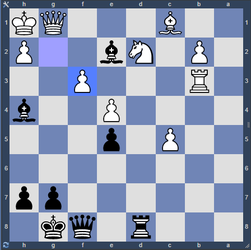

Certainty range [0.999977 - 1], Avg: 0.999997


Prediction: [Lichess analysis](https://lichess.org/analysis/KQ3B2/P2bN1P1/2P3R1/b2P4/3p1P2/8/pp6/1kq1r3)

FEN: KQ3B2/P2bN1P1/2P3R1/b2P4/3p1P2/8/pp6/1kq1r3


0.99977851

In [29]:
makePrediction('http://i.imgur.com/x6lLQQK.png')

Image on which to make prediction: http://i.imgur.com/r2r43xA.png


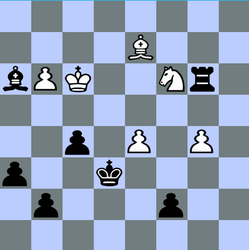

Certainty range [0.645451 - 1], Avg: 0.980475


Prediction: [Lichess analysis](https://lichess.org/analysis/8/4B3/bBK2Nr1/8/2b1B1B1/p2k4/1p3p2/8)

FEN: 8/4B3/bBK2Nr1/8/2b1B1B1/p2k4/1p3p2/8


0.22809464

In [30]:
makePrediction('http://i.imgur.com/r2r43xA.png')

Image on which to make prediction: http://i.imgur.com/gSFbM1d.png


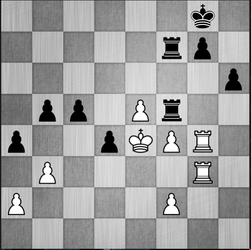

Certainty range [0.999988 - 1], Avg: 0.999998


Prediction: [Lichess analysis](https://lichess.org/analysis/6k1/5rp1/7p/1pp1Pr2/p2pKPR1/1P4R1/P4P2/8)

FEN: 6k1/5rp1/7p/1pp1Pr2/p2pKPR1/1P4R1/P4P2/8


0.99985528

In [31]:
makePrediction('http://i.imgur.com/gSFbM1d.png')

A handful of failures, but we have greater than 98% success for 78% of screenshots, including several out-of-left-field screenshots from mobile chess apps. Certainty is defined as the product of all 64 tile probabilities together, which is a bit stricter than minimum certainty, but shows overall certainty for the board better.

Say two pieces had 90% probability of correctness (the rest are 100%), then the overall certainty for the board should be lower than 90%, 81% in that case.

Looking at the failure cases, it looks like the images from lichess or chess and other more common screenshots were good, the others had a couple to several wrong pieces within. On the whole it actually got most of them correct, and when it didn't the certainty dropped extremely quickly. The certainty range does a good job of being uncertain in the cases where it failed, and 98%+ certain for the success cases.